# Experimentacion

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'model': regr,
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target),
        'standarized_residuals': standarized_residuals,
        'fitted': fitted
    }

# Me da los residuos estandarizados
def residuos(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    standarized_residuals = standarized_residual_plot(fitted, target)
    return np.array(standarized_residuals)


df = pd.read_csv("expectativa_de_vida.csv")

#### Como la cantidad de filas (paises) en el dataset no es demasiado significativa (miles y miles de elementos), no hare un train set que intente ser un fiel representante de todos los datos de la tabla. Sino que utilizare a todos los paises del dataset para realizar experimentos. 
#### En algunos casos, en vez de incluir a todos, me centrare en ciertos grupos en especifico, excluyendo a toda la muestra. Pero esto sera con la intencion de querer demostrar cierta anomalia o dato interesante que nos puedan proveer los datos. Como ejemplo, vere como segmentar y emplear regresion solo con paises encasillados en la condicion de 'Developing' y los que se encuentran en 'Developed'. Tambien habra un modelo con todos los paises, y otro donde no haya outliers. Se trataran a los outliers con suficiente detenimiento para entender su condicion, por que se salen tanto de la norma, son creibles sus datos? O simplemente estan encasillados en una categoria que no les corresponde si se la compara con el resto de su informacion?

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       183 non-null    int64  
 1   Country                          183 non-null    object 
 2   Life expectancy                  183 non-null    float64
 3   Adult Mortality                  183 non-null    float64
 4   infant deaths                    183 non-null    float64
 5   Alcohol                          182 non-null    float64
 6   percentage expenditure           183 non-null    float64
 7   Hepatitis B                      174 non-null    float64
 8   Measles                          183 non-null    float64
 9   BMI                              181 non-null    float64
 10  under-five deaths                183 non-null    float64
 11  Polio                            183 non-null    float64
 12  Total expenditure     

Vemos que 'Status' es de tipo object, no float, como nos es de interes incluirlo en la experimentacion, proximamente vamos a hacer que tenga un valor numerico.

### Gracias al analisis exploratorio de datos provisto en 'EDA.ipynb' se puede descartar la siguiente data:

#### <b>Features 
 - **Hepatitis B**: Se correlaciona mucho con Polio y Diphteria
 - **Alcohol**: No parece ser un indicador que ayude a explicar la expectativa de vida
 - **GDP**: Puede ser reemplazado por Percentage Expenditure
 - **Population**: Se puede reemplazar por Infant Deaths y Under-Five Deaths
 - **Income Composition of Resources y Schooling**: Ambos correlacionan fuerte con BMI

#### <b> Paises
 - **Sudan, Sudan del Sur, Corea del Norte y Somalia**: Todos ellos tienen data incompleta

### Saco a los paises nombrados mas arriba del dataset

In [22]:
df_new = df.drop([150, 153, 44, 148], axis=0)

In [23]:
print(df.shape) # Con todos los paises
print(df_new.shape) # Sin esos paises

(183, 22)
(179, 22)


### Hago que 'Status' tenga un valor float

In [24]:
df_new['Status_Float'] = df_new['Status'].apply(lambda x: 0 if x=='Developing' else 1)

In [25]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 182
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       179 non-null    int64  
 1   Country                          179 non-null    object 
 2   Life expectancy                  179 non-null    float64
 3   Adult Mortality                  179 non-null    float64
 4   infant deaths                    179 non-null    float64
 5   Alcohol                          179 non-null    float64
 6   percentage expenditure           179 non-null    float64
 7   Hepatitis B                      170 non-null    float64
 8   Measles                          179 non-null    float64
 9   BMI                              179 non-null    float64
 10  under-five deaths                179 non-null    float64
 11  Polio                            179 non-null    float64
 12  Total expenditure     

## Busco variables para mis muestras de regresion: Empiezo con el data set que contiene a todos los paises

In [26]:
df_new.corr()['Life expectancy']

Unnamed: 0                         0.009284
Life expectancy                    1.000000
Adult Mortality                   -0.892716
infant deaths                     -0.200913
Alcohol                            0.453856
percentage expenditure             0.523687
Hepatitis B                        0.402502
Measles                           -0.203355
BMI                                0.722210
under-five deaths                 -0.226052
Polio                              0.668041
Total expenditure                  0.279391
Diphtheria                         0.658709
HIV/AIDS                          -0.598270
GDP                                0.609940
Population                        -0.042260
thinness  1-19 years              -0.523232
thinness 5-9 years                -0.515666
Income composition of resources    0.814026
Schooling                          0.794511
Status_Float                       0.500508
Name: Life expectancy, dtype: float64

## Experimentacion 1: Modelo - Enfermedades

### Como el COVID fue por lejos el acontecimiento mas relevante del 2020 y el 2021, centraremos esta etapa de la investigacion en como se relaciona la expectativa de vida a comparacion con que tan propenso es contraer un virus (serio si no es tratado) en dicho pais 

### Vamos a unir en una sola variable todos los virus que aparecen en la tabla, para ver como se correlacionan las enfermedades con la expectativa de vida de un pais. Que paises se espera que se vean mas afectados, y si puede llegar a haber casos extremos que no preveiamos o no condicen con nuestros pensamientos previos al estudio.

### Normalizo los datos de las enfermedades ('Measles', 'HIV/AIDS', 'Polio' y 'Hepatitis B')

In [62]:
features_a_normalizar = ['Measles','HIV/AIDS', 'Polio', 'Hepatitis B', 'Life expectancy']
for feature in features_a_normalizar:
    df_new[f'Normalizado_{feature}'] = (df_new[feature]-np.mean(df_new[feature]))/np.std(df_new[feature])

In [63]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 182
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       179 non-null    int64  
 1   Country                          179 non-null    object 
 2   Life expectancy                  179 non-null    float64
 3   Adult Mortality                  179 non-null    float64
 4   infant deaths                    179 non-null    float64
 5   Alcohol                          179 non-null    float64
 6   percentage expenditure           179 non-null    float64
 7   Hepatitis B                      170 non-null    float64
 8   Measles                          179 non-null    float64
 9   BMI                              179 non-null    float64
 10  under-five deaths                179 non-null    float64
 11  Polio                            179 non-null    float64
 12  Total expenditure     

### Me deshago de los paises que no contengan data sobre el Hepatitis B. Los busco y me armo mi modelo personalizado 'df_virus'

In [64]:
df_virus = df_new[(pd.notnull(df_new["Hepatitis B"]))] 

### Armo el modelo nuevo

In [65]:
df_virus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 0 to 182
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       170 non-null    int64  
 1   Country                          170 non-null    object 
 2   Life expectancy                  170 non-null    float64
 3   Adult Mortality                  170 non-null    float64
 4   infant deaths                    170 non-null    float64
 5   Alcohol                          170 non-null    float64
 6   percentage expenditure           170 non-null    float64
 7   Hepatitis B                      170 non-null    float64
 8   Measles                          170 non-null    float64
 9   BMI                              170 non-null    float64
 10  under-five deaths                170 non-null    float64
 11  Polio                            170 non-null    float64
 12  Total expenditure     

In [66]:
df_virus['enfermedades_all'] = df_virus['Normalizado_Measles'] + df_virus['Normalizado_HIV/AIDS'] - df_virus['Normalizado_Polio'] - df_virus['Normalizado_Hepatitis B'] 

<ipython-input-66-189cfb570861>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_virus['enfermedades_all'] = df_virus['Normalizado_Measles'] + df_virus['Normalizado_HIV/AIDS'] - df_virus['Normalizado_Polio'] - df_virus['Normalizado_Hepatitis B']


In [67]:
df_virus.corr()["Life expectancy"] #Vemos una correlacion aceptable entre los distintos virus que hay y la expectativa de vida

Unnamed: 0                        -0.009464
Life expectancy                    1.000000
Adult Mortality                   -0.887393
infant deaths                     -0.193155
Alcohol                            0.415487
percentage expenditure             0.511175
Hepatitis B                        0.402502
Measles                           -0.201311
BMI                                0.724400
under-five deaths                 -0.219068
Polio                              0.659608
Total expenditure                  0.230055
Diphtheria                         0.652492
HIV/AIDS                          -0.601532
GDP                                0.585880
Population                        -0.023562
thinness  1-19 years              -0.496203
thinness 5-9 years                -0.487267
Income composition of resources    0.798249
Schooling                          0.779184
Status_Float                       0.451057
Normalizado_Measles               -0.201311
Normalizado_HIV/AIDS            

### Al sumar las variables vemos que a mayor incidencia de un virus, menor la expectativa de vida, por eso la correlacion es negativa

### Corro el analisis de regresion 

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     144.8
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.87e-24
Time:                        15:45:24   Log-Likelihood:                -560.93
No. Observations:                 170   AIC:                             1126.
Df Residuals:                     168   BIC:                             1132.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.0116      0.506    136.363      0.0

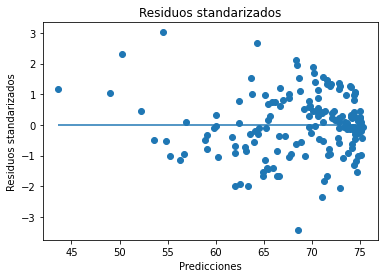

<Figure size 2160x2160 with 0 Axes>

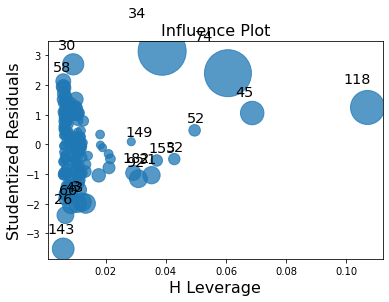

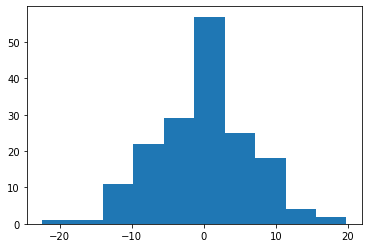

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e13a42730>,
 'r2': 0.4629982712326227,
 'rmse': 6.557675023120022,
 'adjusted': 0.4598018323709121,
 'standarized_residuals': 0     -0.735508
 1      0.009965
 2      0.387087
 3     -1.978627
 4      0.015059
          ...   
 178    0.883301
 179    0.402792
 180   -0.088975
 181   -0.786838
 182   -0.954366
 Name: Life expectancy, Length: 170, dtype: float64,
 'fitted': array([63.01697394, 75.09090583, 71.08035747, 61.99393969, 74.95749873,
        72.26119712, 72.39166894, 72.85295734, 71.15590629, 66.72893945,
        72.78480267, 75.10175476, 69.69332803, 70.67457274, 72.74420088,
        71.9880277 , 74.14657962, 65.07402724, 73.20365701, 70.76413805,
        68.77377718, 65.3408425 , 74.87185757, 74.99762655, 73.68530726,
        66.5256153 , 71.02874062, 70.67856345, 68.33661619, 64.89998763,
        64.28506348, 55.25986128, 53.6074028 , 70.33638751, 54.4639841 ,
        70.65659152, 67.87108213, 

In [68]:
run_analysis(['enfermedades_all'], df_virus)

### Grafico con el metodo de cuadrados minimos

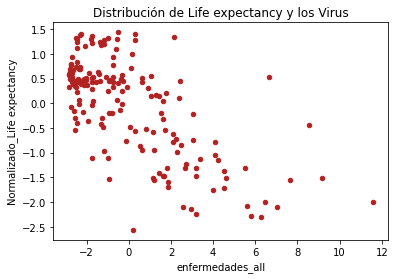

In [73]:
fig_virus, ax_virus = plt.subplots()

df_virus.plot(
    x    = 'enfermedades_all',
    y    = 'Normalizado_Life expectancy',
    c    = 'firebrick',
    kind = "scatter",
    ax   = ax_virus
)

#ACA PONDRIA LA RECTA DE REGRESION CON LA FUNCION DE C++ !!!FALTA ESTO!!!

ax_virus.set_title('Distribución de Life expectancy y los Virus');

## Busqueda de outliers

### Quito outliers y vuelvo a hacer el analisis para ver como cambian los datos arrojados

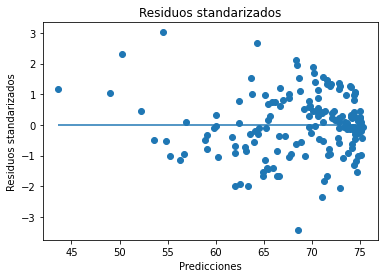

In [74]:
residuos_virus = residuos(['enfermedades_all'], df_virus)

/home/tincho/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

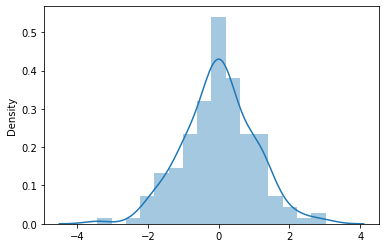

In [76]:
sns.distplot(residuos_virus)

### Como primer medida tengo que atender los casos donde el modulo del residuo sea mayor a 2.5 (desviacion estandar), ellos son outliers. Tambien tengo que prestar atencion a los casos donde el diametro de la distancia de Cook es muy grande y la palanca que realiza ese punto (Leverage) es considerable.
### Teniendo en cuenta esos 3 casos, puedo quedarme con un modelo con un ajuste muchisimo mas fiable ya que estoy dejando de lado a los casos mas extremos de la muestra, que pueden complicar la estimacion de todo el modelo

In [79]:
df_virus = df_virus.assign(residuos_virus = residuos_virus)

In [81]:
#Busco outliers por el lado de los residuos
df_virus[(df_virus["residuos_virus"]**2)**0.5 > 2.5] 

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Schooling,Status,Status_Float,Normalizado_Measles,Normalizado_HIV/AIDS,Normalizado_Polio,Normalizado_Hepatitis B,Normalizado_Life expectancy,enfermedades_all,residuos_virus
30,30,Canada,81.6875,64.6250,2.0000,8.053333,4694.078971,28.846154,129.5000,55.86250,...,15.87500,Developing,0,-0.282681,-0.370526,0.159540,-2.968750,1.346474,2.156003,2.653751
34,34,China,74.2625,73.7500,294.8750,4.182000,73.583763,80.437500,65857.9375,21.80625,...,11.43750,Developing,0,7.790238,-0.370526,0.706624,0.077175,0.530109,6.635913,3.019136
143,152,Sierra Leone,46.1125,357.8125,27.5625,3.154667,29.105579,83.444444,673.8750,18.30625,...,8.23125,Developing,0,-0.215820,-0.053753,-0.726409,0.254704,-2.564934,0.202133,-3.424374


### Como primer outlier destacable vemos a China, que tiene un valor normalizado de 'Measles' de 7.79, MUY por encima del resto. Nos deshacemos de el y del resto de paises en esta lista. Hay que decir que son bastante pocos, por lo que el conjunto de todos los datos no se desvia mucho de la prediccion.

In [82]:
df_virus_no_outliers = df_virus[(df_virus["residuos_virus"]**2)**0.5 <= 2.5] 

### Ahora me encargo de la distancia de Cook y el Leverage y termino de extraer a los ultimos outliers

In [115]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

# Me da la distancia de Cook de cada pais
def cooksDist(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    # cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
    C, P = inf.cooks_distance
    return C, P

In [116]:
cook_virus, p_virus = cooksDist(['enfermedades_all'], df_virus)

In [117]:
cook_virus.shape

(170,)

In [118]:
df_virus2 = df_virus.assign(cook_virus = cook_virus)

### Estos son los paises con mayor distancia de Cook (circulo mas grande). Los saco de la muestra. Notar que China ya habia aparecido como outlier en el test de residuos.

In [119]:
df_virus2[df_virus2["cook_virus"] > 0.05]

KeyError: 'cook_virus'

In [120]:
cook_virus_no_outliers, p_virus_no_outliers = cooksDist(['enfermedades_all'], df_virus_no_outliers)

In [122]:
df_virus_no_outliers = df_virus_no_outliers.assign(cook_virus = cook_virus_no_outliers)

In [123]:
df_virus_no_outliers = df_virus_no_outliers[df_virus_no_outliers["cook_virus"] < 0.05]

In [126]:
print(df_virus_no_outliers.shape)
print(df_virus.shape) 

(164, 31)
(170, 30)


### Ya nos deshicimos de 6 outliers, ahora veamos la condicion de leverage y terminamos con la quita 

In [127]:
# Me da el Leverage de cada pais
def getLeverage(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    leverage = inf.hat_matrix_diag
    return leverage

In [134]:
leverage_no_outliers = getLeverage(['enfermedades_all'], df_virus_no_outliers)

In [136]:
df_virus_no_outliers = df_virus_no_outliers.assign(leverage_virus = leverage_no_outliers)

In [150]:
df_virus_no_outliers = df_virus_no_outliers[df_virus_no_outliers["leverage_virus"] < 0.04]

In [151]:
print(df_virus_no_outliers.shape)
print(df_virus.shape) 

(157, 32)
(170, 30)


### Ya me deshice de los paises con mayor Leverage. Por lo tanto termine de eliminar los maximos outliers de la muestra. Ahora realizo el analisis de regresion sin outliers en mi modelo

## Analisis sin outliers

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     133.2
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.24e-22
Time:                        17:43:43   Log-Likelihood:                -501.23
No. Observations:                 157   AIC:                             1006.
Df Residuals:                     155   BIC:                             1013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.6637      0.485    141.669      0.0

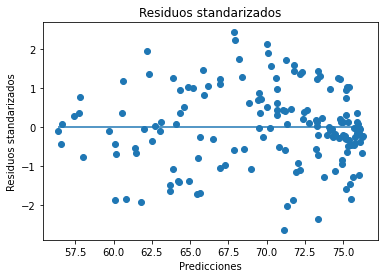

<Figure size 2160x2160 with 0 Axes>

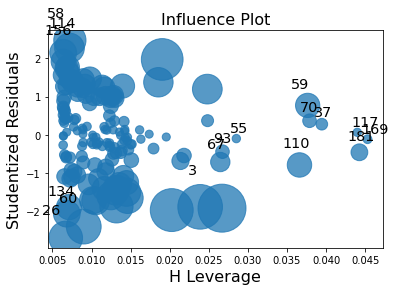

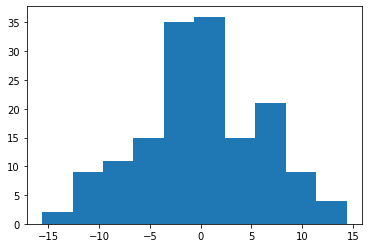

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f7e1146dc70>,
 'r2': 0.4621789146569665,
 'rmse': 5.89204319377403,
 'adjusted': 0.45870910120314046,
 'standarized_residuals': 0     -0.537564
 1     -0.155007
 2      0.413242
 3     -1.883233
 4     -0.144396
          ...   
 177    1.269732
 178    1.094583
 179    0.391716
 180    0.129088
 181   -0.448380
 Name: Life expectancy, Length: 157, dtype: float64,
 'fitted': array([61.36110213, 76.06955567, 71.18390908, 60.11484268, 75.90703926,
        72.62240693, 72.7813476 , 73.34328872, 71.27594259, 65.88301535,
        73.26026276, 76.08277183, 69.49423099, 70.68958246, 73.2108017 ,
        72.28963218, 74.91917829, 63.86700271, 73.77051076, 70.79869084,
        68.37403493, 64.19203684, 75.80271127, 75.95592293, 74.35725669,
        65.63532605, 71.12102947, 70.69444394, 67.84148579, 63.65498781,
        70.2776055 , 70.66767775, 67.27437259, 57.42179008, 68.22315265,
        75.34105235, 75.90926921, 

In [152]:
run_analysis(['enfermedades_all'], df_virus_no_outliers)

## Mayor R2 con menos variables

### Por ultimo veo como se puede tener un mejor ajuste al tener menos variables en juego